In [1]:
%matplotlib inline

In [2]:
# Third party imports
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Local imports
from libcomcat.dataframes import get_history_data_frame, split_history_frame, PRODUCTS
from libcomcat.search import get_event_by_id

# ComCat Event History

Use this function to download a summary DataFrame of all of the products associated with a given ComCat ID. The M7.1 event from the Ridgecrest Earthquake Sequence in July 2019 is used in this example.

In [3]:
history_event = get_event_by_id('ci38996632')
dataframe, event = get_history_data_frame(history_event)

Use head() to inspect the columns and first five rows. The products are sorted by "update time", which is supposed to be the time the PDL client sends the product, but some producers override this manually.

In [4]:
print(len(dataframe))
dataframe.head()

13


,Update Time,Product,Authoritative Event ID,Code,Associated,Product Source,Product Version,Elapsed (min),URL,Comment,Description
4,2019-08-22 20:54:59.280,moment-tensor,ci38996632,ci38996632,True,ci,1,5.2,https://earthquake.usgs.gov/archive/product/mo...,,Method# TMTS|Moment Magnitude# 5.0|Depth# 11|D...
6,2019-08-22 21:17:09.990,origin,ci38996632,ci38996632,True,ci,1,27.3,https://earthquake.usgs.gov/archive/product/or...,,Magnitude# 5.0|Time# 2019-08-22 20:49:50.06000...
8,2019-08-22 21:17:09.990,phase-data,ci38996632,ci38996632,True,ci,1,27.3,https://earthquake.usgs.gov/archive/product/ph...,,Magnitude# 5.0|Time# 2019-08-22 20:49:50.06000...
1,2019-08-22 21:18:25.870,focal-mechanism,ci38996632,ci38996632,True,ci,1,28.6,https://earthquake.usgs.gov/archive/product/fo...,,Method# HaSh|NP1 Strike# 349.0|NP1 Dip# 83.0|N...
11,2019-08-22 21:51:45.173,shakemap,ci38996632,ci38996632,True,ci,5,61.9,https://earthquake.usgs.gov/archive/product/sh...,,MaxMMI# 6.1|Instrumented# 0|DYFI# 0|Fault# |GM...


The dataframe downloaded has all kinds of products in it. It can be used with the split_history_frame() function to extract just the origins and look at those.

In [5]:
origin_frame = split_history_frame(dataframe,product='origin')
origin_frame

,Update Time,Product,Authoritative Event ID,Code,Associated,Product Source,Product Version,Elapsed (min),URL,Comment,Magnitude,Time,Time Offset (sec),Location,Distance from Auth. Origin (km),Azimuth,Depth,Magnitude Type,Location Method,Preferred Weight
0,2019-08-22 21:17:09.990,origin,ci38996632,ci38996632,True,ci,1,27.3,https://earthquake.usgs.gov/archive/product/or...,,5.0,2019-08-22 20:49:50.060,0.0,"(35.907,-117.709)",0.0,N,2.4,mw,unknown,156.0
1,2019-09-24 15:30:04.040,origin,ci38996632,us70005795,True,us,1,47200.2,https://earthquake.usgs.gov/archive/product/or...,,5.0,2019-08-22 20:49:50.060,0.0,"(35.907,-117.709)",0.0,S,2.4,mwr,unknown,6.0


Make a plot showing all of the depths, colored by contributing network.

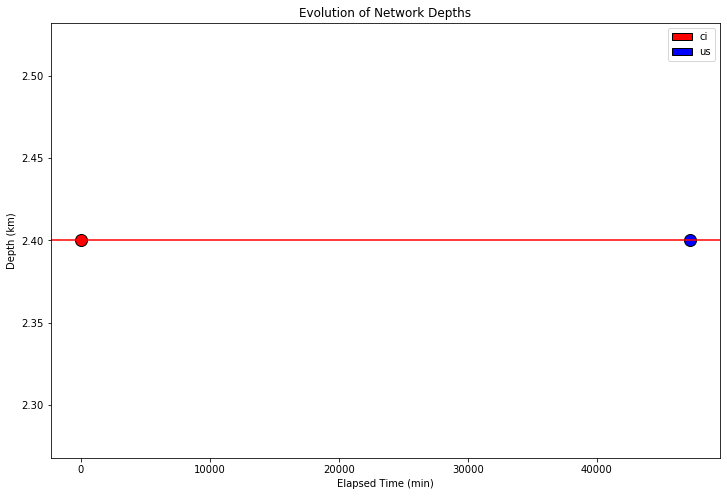

In [6]:
fig = plt.figure(figsize=(12,8))
colors = ['r','b','g','k','m']
nets = origin_frame['Product Source'].unique().tolist()
labels = {}
for idx, row in origin_frame.iterrows():
    netidx = nets.index(row['Product Source'])
    color = colors[netidx]
    line = plt.plot(row['Elapsed (min)'],row['Depth'], mfc=color,mec='k',marker='.', ms=24)
    if color not in labels:
        labels[color] = nets[netidx]

patches = []
for color, network in labels.items():
    tpatch = mpatches.Circle(xy=(0,0),color=color, label=network, ec='k')
    patches.append(tpatch)
plt.legend(handles=patches);
plt.title('Evolution of Network Depths');
plt.xlabel('Elapsed Time (min)');
plt.ylabel('Depth (km)');
plt.axhline(y=event.depth,color='r');

Let's similarly split out DYFI products.

In [7]:
dyfi_frame = split_history_frame(dataframe,product='dyfi')
print(len(dyfi_frame))
dyfi_frame.head()

1


,Update Time,Product,Authoritative Event ID,Code,Associated,Product Source,Product Version,Elapsed (min),URL,Comment,Max MMI,NumResponses
0,2019-09-14 02:00:53.424,dyfi,ci38996632,ci38996632,True,us,1,31991.1,https://earthquake.usgs.gov/archive/product/dy...,,4.8,1266.0


DYFI product updates arrive frequently, so a figure showing the number of responses with time may be useful.

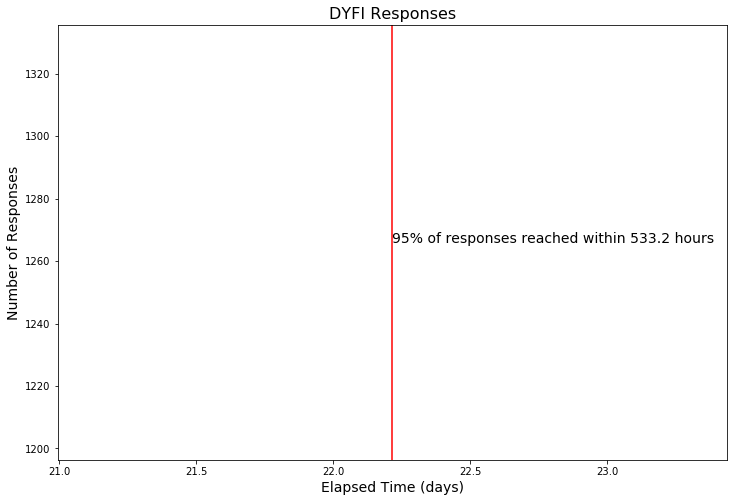

In [8]:
fig = plt.figure(figsize=(12,8));
plt.plot(dyfi_frame['Elapsed (min)']/(60*24), dyfi_frame['NumResponses'], 'b');
plt.xlabel('Elapsed Time (days)', fontsize=14);
plt.ylabel('Number of Responses', fontsize=14);
plt.title('DYFI Responses', fontsize=16);
# how long did it take to get to 95% of our maximum number of responses?
max_resp_95 = dyfi_frame['NumResponses'].max()*0.95
elapsed = dyfi_frame[dyfi_frame['NumResponses'] >= max_resp_95].iloc[0]['Elapsed (min)']
elapsed_x = elapsed/(60*24)
elapsed_hrs = elapsed/60
plt.axvline(x=elapsed_x,color='r');
etext = '95%% of responses reached within %.1f hours' % elapsed_hrs
plt.text(elapsed_x, dyfi_frame['NumResponses'].mean(),etext, fontsize=14);

Retrieve ShakeMap data

In [9]:
sm_frame = split_history_frame(dataframe,product='shakemap')
print(len(sm_frame))
sm_frame.head()

4


,Update Time,Product,Authoritative Event ID,Code,Associated,Product Source,Product Version,Elapsed (min),URL,Comment,MaxMMI,Instrumented,DYFI,Fault,GMPE,Mag,Depth
0,2019-08-22 21:51:45.173,shakemap,ci38996632,ci38996632,True,ci,5,61.9,https://earthquake.usgs.gov/archive/product/sh...,,6.1,0.0,0.0,NaN,NaN,NaN,NaN
1,2019-08-23 08:53:49.780,shakemap,ci38996632,ci38996632,True,cgs,4,724.0,https://earthquake.usgs.gov/archive/product/sh...,,6.5,476.0,0.0,NaN,BA08,5.0,2.4
2,2019-08-23 20:52:27.444,shakemap,ci38996632,ci38996632,True,ci,6,1442.6,https://earthquake.usgs.gov/archive/product/sh...,,6.6,558.0,0.0,NaN,BA08,5.0,2.4
3,2019-08-27 10:48:13.455,shakemap,ci38996632,ci38996632,True,us,24,6598.4,https://earthquake.usgs.gov/archive/product/sh...,,6.0,668.0,97.0,NaN,"AbrahamsonEtAl2014,BooreEtAl2014CaliforniaBasi...",5.0,2.4


Select the Southern California ShakeMaps

In [10]:
ci_frame = sm_frame[sm_frame['Product Source'] == 'ci']
ci_frame.head()

,Update Time,Product,Authoritative Event ID,Code,Associated,Product Source,Product Version,Elapsed (min),URL,Comment,MaxMMI,Instrumented,DYFI,Fault,GMPE,Mag,Depth
0,2019-08-22 21:51:45.173,shakemap,ci38996632,ci38996632,True,ci,5,61.9,https://earthquake.usgs.gov/archive/product/sh...,,6.1,0.0,0.0,NaN,NaN,NaN,NaN
2,2019-08-23 20:52:27.444,shakemap,ci38996632,ci38996632,True,ci,6,1442.6,https://earthquake.usgs.gov/archive/product/sh...,,6.6,558.0,0.0,NaN,BA08,5.0,2.4


Plot the number of instrumented stations over time

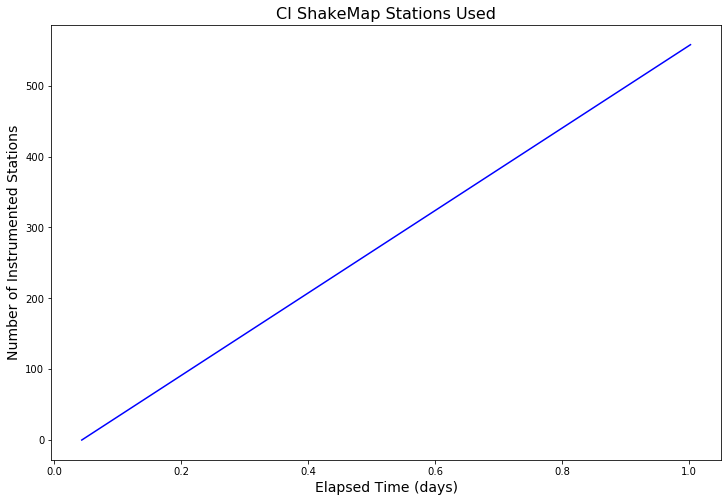

In [11]:
fig = plt.figure(figsize=(12,8));
plt.plot(ci_frame['Elapsed (min)']/(60*24), ci_frame['Instrumented'], 'b');
plt.xlabel('Elapsed Time (days)', fontsize=14);
plt.ylabel('Number of Instrumented Stations', fontsize=14);
plt.title('CI ShakeMap Stations Used', fontsize=16);